In [7]:
# importing necessary libraries and pakages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from optbinning import OptimalBinning
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import  SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore
import xgboost
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble.gradient_boosting import  GradientBoostingClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import  AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
import warnings
warnings.filterwarnings('ignore')
sb.set()

In [8]:
ds = pd.read_csv('loan_prediction.csv')
ds

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


### EDA and Data-preprocessing

In [9]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


From above info data, we can infer that there are missing values.

In [10]:
ds.Loan_Status.value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

From above data, it is clear that the data-set is imbalanced, in which minor class being Loan_Status 'No'. So, we shall keep in mind that to use appropriate metrics for model evaluation.

In [11]:
print('Null accuracy:',round(ds.Loan_Status.value_counts()[0]/ds.Loan_Status.value_counts().sum(),2)*100)

Null accuracy: 69.0


Here, we see null accuracy of about 69 %, i.e. even if the model predicts all instances of data as Loan approved (i.e. Yes), the accuracy will be 69 %, which is a bad prediction, as it is not taking account of status of not approving Loan (i.e. No), which is an important factor for fraud loan applicants.

In [12]:
# here we are separating the categoric and numeric columns for separate analysis.
numeric_col = []
cat_col = []

for col in ds.columns:
    if col in ds.describe().columns:
        
        numeric_col.append(col)
    else:
        cat_col.append(col)
        
print('numeric columns: \n',numeric_col,'\n')
print('categorical columns: \n',cat_col)

numeric columns: 
 ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History'] 

categorical columns: 
 ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


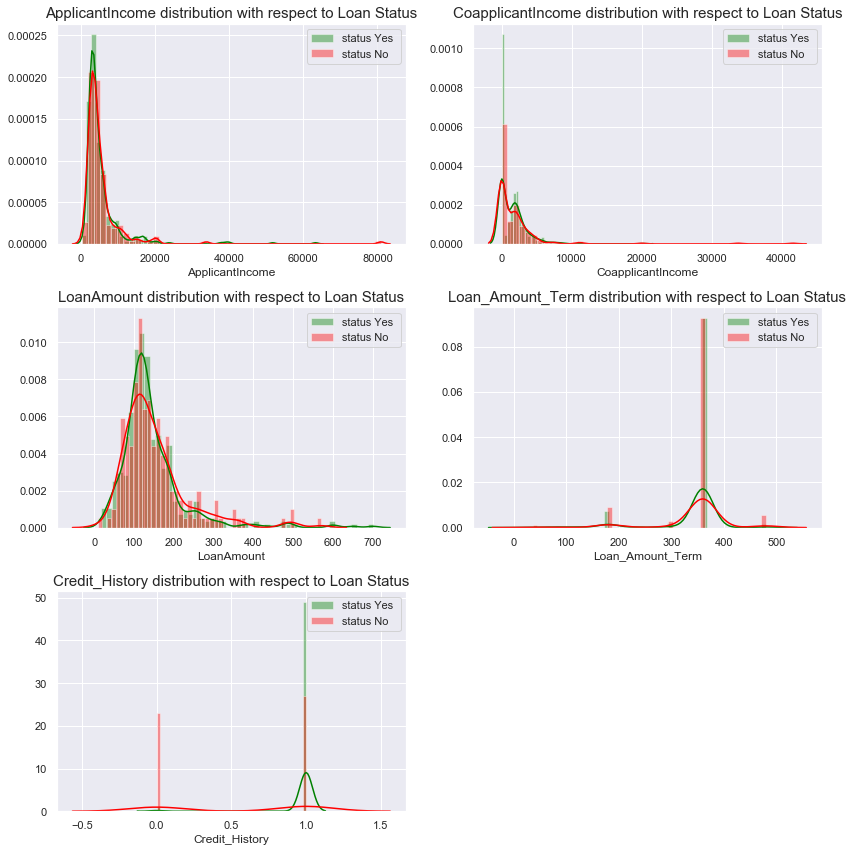

In [13]:
for i, col in enumerate(numeric_col):
    
    plt.subplot(3,2, i+1)

    sb.distplot(ds[col][ds['Loan_Status'] == 'Y'], kde = True, bins = 50 , color = 'green')
    sb.distplot(ds[col][ds['Loan_Status'] == 'N'], kde = True, bins = 50, color = 'red')


    plt.legend(['status Yes ','status No'])

    plt.title(col+' distribution with respect to Loan Status', fontsize = 15)
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(12,12)
    plt.tight_layout()
plt.show()

From above plots, we see that distributions of data is highly skewed containing possible outliers.

Also, we can observe that columns like Credit_History and Loan_Amount_Term are rather discrete values. So, we shall treat them differently.

In [14]:
# defining function that visualizes probabilities of each catrgories for loan approval.
def loan_prob_chart(feature):
        plt.figure(figsize = (8,6))
        yes = ds[ds['Loan_Status'] == 'Y'][feature].value_counts()
        no = ds[ds['Loan_Status'] == 'N'][feature].value_counts()
        df = pd.DataFrame([yes,no])
        df.index = ['status Yes','status No']
        df = df.T
        df['prob%'] = (df['status Yes']/(df['status Yes'] + df['status No']))*100
       
        sb.barplot(x = df.index, y = 'prob%', data = df, palette = 'deep')
        plt.ylabel('Probability of Loan approval (%)', fontsize = 15)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.xlabel('Classes of ' + feature, fontsize = 15)
        plt.yticks(fontsize = 15)
        plt.title( 'Probability of Loan approval in '   + feature +' Category', fontsize = 16)
        plt.show()

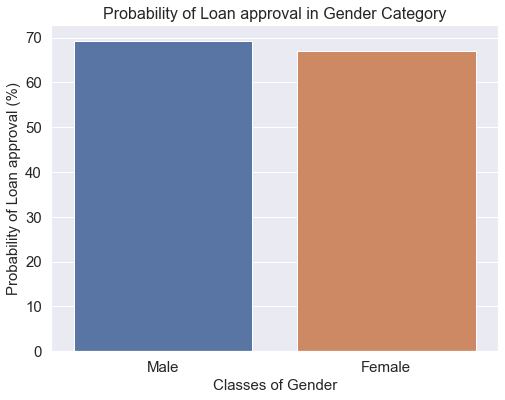

In [15]:
loan_prob_chart('Gender')

Here we see that Male customers may have slightly higher chances of Loan approval.

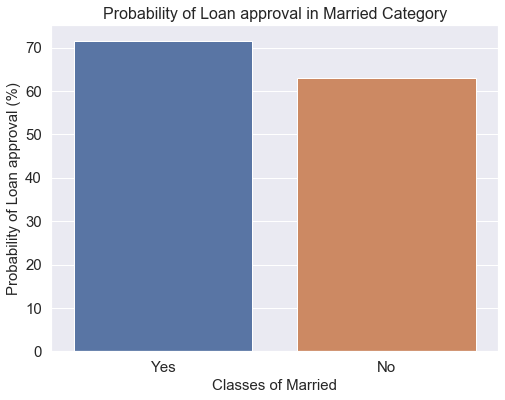

In [16]:
loan_prob_chart('Married')

People who are Married has higher chances of loan approval.

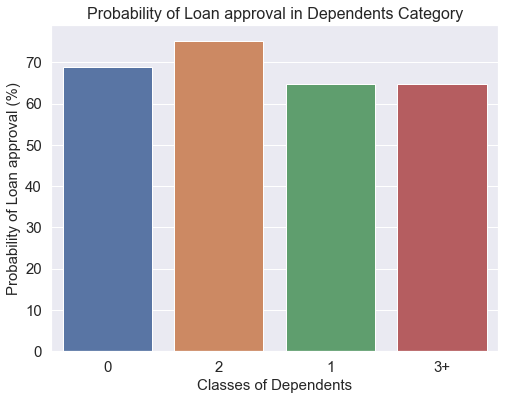

In [17]:
loan_prob_chart('Dependents')

Here we see that Dependents class 2 has the higher chances of getting loan approval compared to other class.

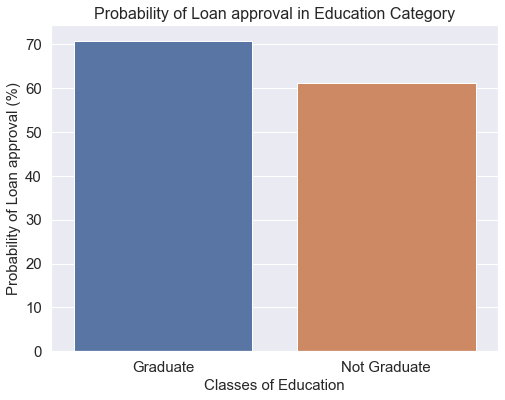

In [18]:
loan_prob_chart('Education')

From above plots, for obvious reasons, people who are Graduates have higer chances of loan approval then the Non-Graduates.

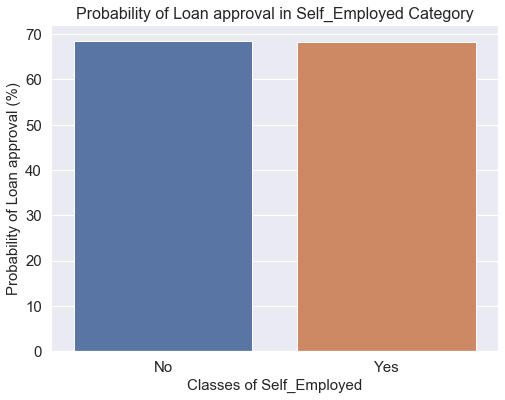

In [19]:
loan_prob_chart('Self_Employed')

Here we see that, no significant difference for chances of loan approval for whether a person may be self-employed or not.

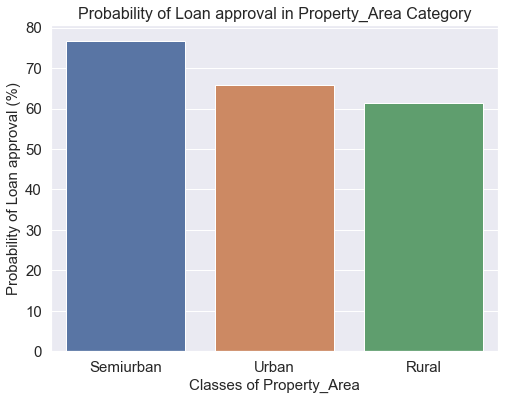

In [20]:
loan_prob_chart('Property_Area')

We see that property belonging to Semiurban areas has the highest chances of loan approval followed by Urban and then Rural areas.

In [21]:
ds.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

From above data we see some missing data, to which we shall impute.

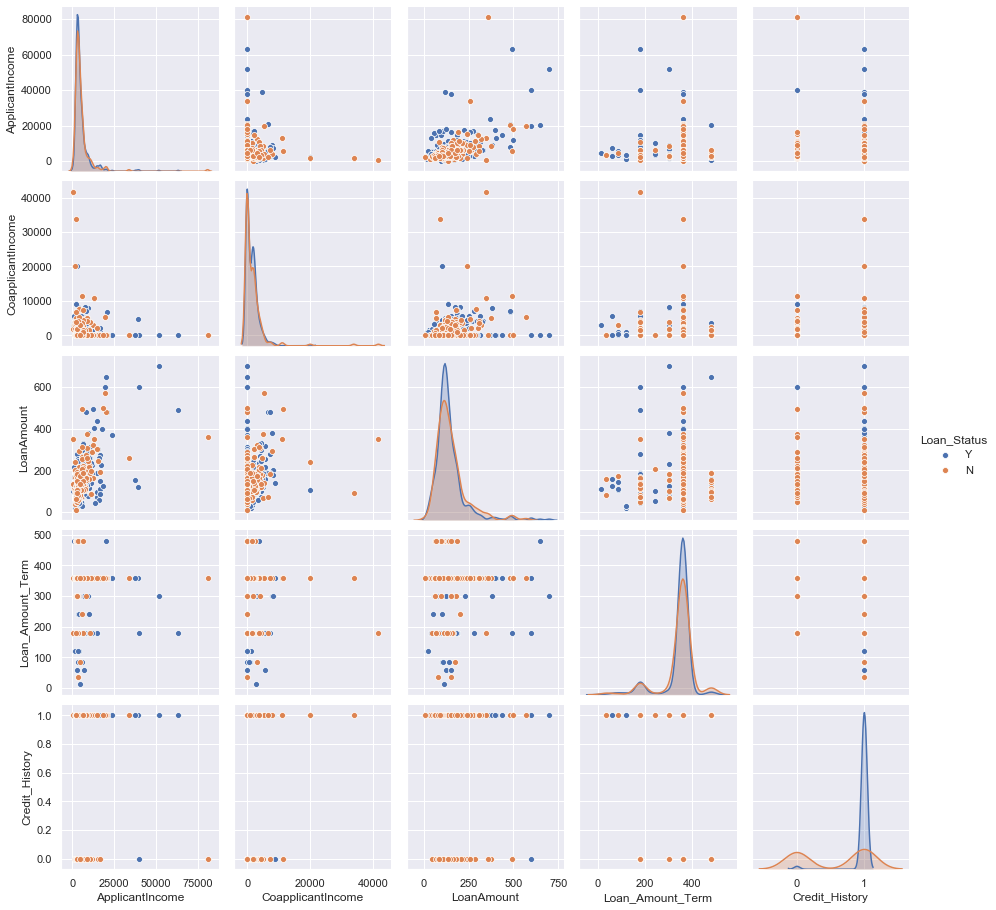

In [22]:
numeric_col.append('Loan_Status')
sb.pairplot(ds[numeric_col], hue = 'Loan_Status')

From above pairplots, we can see that, data points representing loan status 'Yes' and 'No' are not linearly seperable.

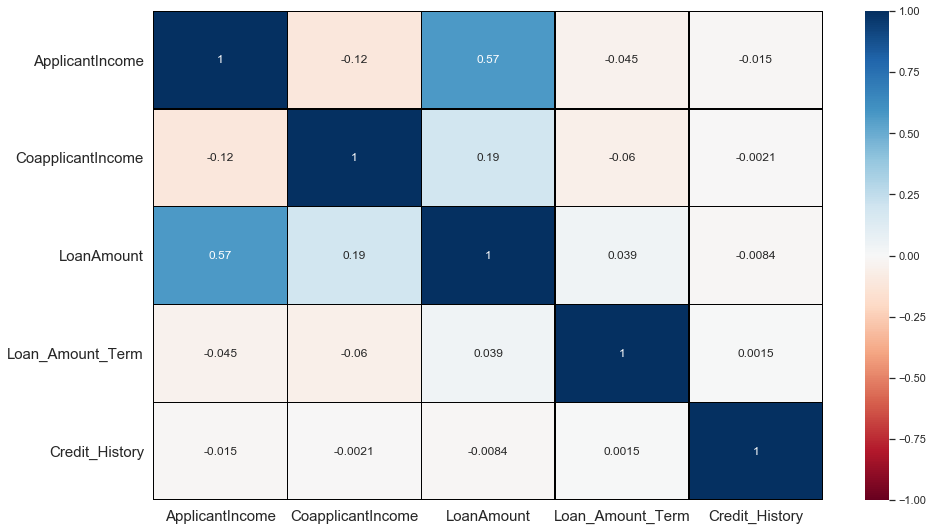

In [23]:
plt.figure(figsize = (15,9))
sb.heatmap(ds[numeric_col].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above heatmap, there are no correlations except for ApplicantIncome and Loan amount with 0.57.
Which makes sense, as LoanAmount would depend on our ability to repay it, which further depends on our income.

In [24]:
for col in numeric_col:
    print('no. of unique values of column ' + col + ': ', len(ds[col].unique()))

no. of unique values of column ApplicantIncome:  505
no. of unique values of column CoapplicantIncome:  287
no. of unique values of column LoanAmount:  204
no. of unique values of column Loan_Amount_Term:  11
no. of unique values of column Credit_History:  3
no. of unique values of column Loan_Status:  2


From above data we see that 'Loan_Amount_Term' and 'Credit_History' has the unique value of only 11 and 3 respectively. Therefore, we shall treat them as ordinal categorical variables.

In [25]:
ds.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Here we see see some  missing values on respective columns, so, we shall impute them with the help of other columns as grouped together.

In [26]:
# imputing missing values in Married columns  by its mode.
ds['Married'].fillna(ds['Married'].mode()[0], inplace  = True)

In [27]:
# imputing missing values in Loan_Amount_Term  columns  by its  grouped median.
ds['Loan_Amount_Term'] = ds.groupby(['Property_Area',
    'Education'])['Loan_Amount_Term'].transform(lambda x: x.fillna(x.median()))

In [28]:
# imputing missing values in LoanAmount  columns  by its  grouped mode.
ds['LoanAmount'] = ds.groupby(['Property_Area',
    'Education'])['LoanAmount'].transform(lambda x: x.fillna(x.mode()[0]))


In [29]:
# imputing missing values in Credit_History columns  by its grouped mode.
ds['Credit_History'] = ds.groupby(['Property_Area',
    'Education'])['Credit_History'].transform(lambda x: x.fillna(x.mode()[0]))

In [30]:
# imputing missing values in Dependents columns  by its grouped mode.
ds['Dependents'] = ds.groupby(['Property_Area',
    'Education'])['Dependents'].transform(lambda x: x.fillna(x.mode()[0]))

In [31]:
# imputing missing values in Dependents columns  by its grouped mode.
ds['Self_Employed'] = ds.groupby(['Property_Area',
    'Education'])['Self_Employed'].transform(lambda x: x.fillna(x.mode()[0]))

In [32]:
# imputing missing values in Dependents columns  by its grouped mode.
ds['Gender'] = ds.groupby(['Property_Area',
    'Education'])['Gender'].transform(lambda x: x.fillna(x.mode()[0]))

In [33]:
ds['Loan_Status'] = ds['Loan_Status'].map({'Y':1, 'N':0 })

In [34]:
ds

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,110.0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1


In [35]:
 # splitting data into train-test set.
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['Loan_Status','Loan_ID'],1), 
                                                     ds.Loan_Status ,
                                                     stratify = ds.Loan_Status,
                                                     random_state = 42,
                                                     test_size = 0.3)

In [36]:
cat_col.remove('Loan_ID') # removing Loan_ID as it is unique for every rows.
cat_col.remove('Loan_Status') # removing Loan_Status, as we have taken account of it in target variable.

In [37]:
# appending 'Credit_History' and 'Loan_Amount_Term' in categorical column.
cat_col.append('Credit_History') 
cat_col.append('Loan_Amount_Term')

In [38]:
# supervised binning categorical columns using 'OptimalBinning' class.
for col in  cat_col:
    
    optb = OptimalBinning(name =  col, dtype= 'categorical',
                      solver='mip',
                      class_weight = 'balanced',
                      cat_cutoff  = 0.1)
    
    optb.fit(x_train[col].values, y_train)
    print('binning status for column ' + col+ ' is',optb.status,'\n')
    
    x_train[col] = optb.transform(x_train[col].values , metric='woe')
    x_test[col] = optb.transform(x_test[col].values , metric='woe')

binning status for column Gender is OPTIMAL 

binning status for column Married is OPTIMAL 

binning status for column Dependents is OPTIMAL 

binning status for column Education is OPTIMAL 

binning status for column Self_Employed is OPTIMAL 

binning status for column Property_Area is OPTIMAL 

binning status for column Credit_History is OPTIMAL 

binning status for column Loan_Amount_Term is OPTIMAL 



Here, we are transforming  categorical variables based on weight of evidence (WOE).

In [39]:
# supervised binning numerical columns using 'OptimalBinning' class.

numeric_col_new = ['ApplicantIncome','CoapplicantIncome','LoanAmount']

for col in  numeric_col_new:
    
    optb = OptimalBinning(name =  col, dtype="numerical",
                      solver="cp",
                      outlier_detector  =  'range',
                      class_weight = 'balanced')
    optb.fit(x_train[col].values, y_train)
    print('binning status for column ' + col+ ' is',optb.status,'\n')
    
    x_train[col] = optb.transform(x_train[col].values , metric='woe')
    x_test[col] = optb.transform(x_test[col].values , metric='woe')

binning status for column ApplicantIncome is OPTIMAL 

binning status for column CoapplicantIncome is OPTIMAL 

binning status for column LoanAmount is OPTIMAL 



Here, we are binning  numerical variables based on Weight of Evidence (WOE). Also by doing so, we don't have to bother about extreme values/outliers as they will be accounted within a binned group.

In [40]:
x_train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
197,0.028171,0.241162,0.103678,0.430783,-0.026424,-0.174694,-0.083553,-0.143548,-0.084264,-0.453952,0.167054
175,-0.005634,-0.130620,0.103678,-0.128617,-0.026424,0.072718,-0.083553,-0.143548,-0.084264,-0.453952,0.351398
526,-0.005634,-0.130620,0.103678,-0.128617,-0.026424,0.072718,-0.083553,-0.143548,-0.084264,-0.453952,-0.510826
149,-0.005634,-0.130620,0.103678,-0.128617,-0.026424,0.736165,-0.083553,-0.143548,-0.084264,-0.453952,-0.510826
507,-0.005634,0.241162,0.103678,-0.128617,-0.026424,0.072718,-0.083553,-0.143548,-0.084264,-0.453952,0.167054
...,...,...,...,...,...,...,...,...,...,...,...
14,-0.005634,-0.130620,-0.693147,-0.128617,-0.026424,-0.174694,-0.083553,-0.485508,0.460159,-0.453952,0.167054
297,0.028171,-0.130620,0.205852,-0.128617,-0.026424,0.736165,-0.083553,-0.143548,-0.084264,-0.453952,0.167054
395,-0.005634,-0.130620,-0.693147,-0.128617,-0.026424,-0.174694,-0.083553,-0.143548,-0.084264,-0.453952,-0.510826
310,0.028171,0.241162,0.103678,-0.128617,-0.026424,-0.174694,-0.083553,-0.143548,-0.084264,-0.453952,-0.510826


In [41]:
k =  KFold(n_splits = 10)

### Base Model Evaluation

model: RandomForestClassifier()
CV score:0.7232211182877861
score_std: 0.104152075367727
----------
model: LogisticRegression()
CV score:0.7453741767746128
score_std: 0.06600284304118267
----------
model: SVC()
CV score:0.7408520028302922
score_std: 0.05557516715615025
----------
model: AdaBoostClassifier()
CV score:0.7276003884227874
score_std: 0.06572782770309198
----------
model: GradientBoostingClassifier()
CV score:0.7327994115561232
score_std: 0.08519518567061524
----------
model: KNeighborsClassifier()
CV score:0.733444075655137
score_std: 0.08203678143258557
----------
model: XGBClassifier(silent=True)
CV score:0.7272404647222798
score_std: 0.09541281310635882
----------
model: DecisionTreeClassifier()
CV score:0.6719925787490111
score_std: 0.0900515717077028
----------
model: GaussianNB()
CV score:0.7460578456252589
score_std: 0.05173648625394119
----------


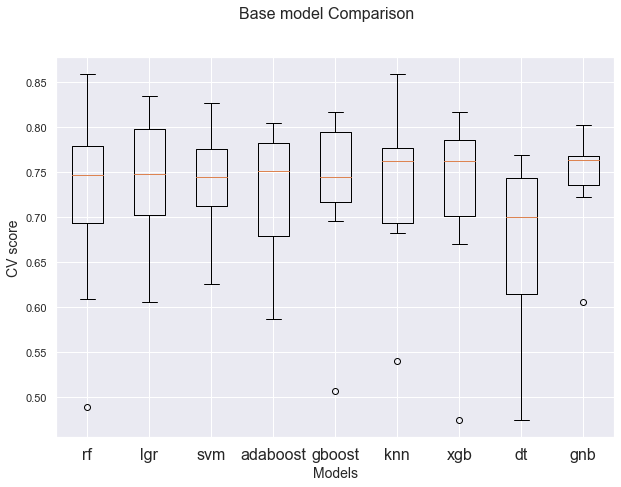

In [42]:
rf = RandomForestClassifier()
svm = SVC()
lgr = LogisticRegression()
adaboost =  AdaBoostClassifier()
gboost = GradientBoostingClassifier()
knn = KNeighborsClassifier()
xgb = xgboost.XGBClassifier(silent = True)
dt = DecisionTreeClassifier()
gnb = GaussianNB()

models = [rf, lgr, svm, adaboost, gboost, knn, xgb, dt, gnb]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train, y_train, cv = k, scoring = 'f1_macro', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rf', 'lgr','svm', 'adaboost', 'gboost', 'knn', 'xgb','dt','gnb'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 14)
plt.ylabel('CV score', fontsize = 14)
fig.set_size_inches(10,7)
plt.show() 

From above cross-val-score, we shall choose all models for tuning and testing, except for dt model, based on overall mean and median cross-val-score.

### Hyper-parameter Tuning

In [43]:
# initializing all model's parameter
param_gboost =  dict(
   learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5, 0.6 ],
   max_depth = [ 2, 3, 4, 5, 6, 8, 10, 12, 15],
   n_estimators = [30 ,50,75,100, 150, 200],
   min_samples_split = [1,2,3],
   min_samples_leaf = [1,2], random_state = [41,42,43])

param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 2, 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ], alpha = [0.05,0.1,0.5,0.75,1,1.75,2],
                 reg_lambda = [0.05,0.1,0.5,0.75,1,1.75,2])

param_lgr = dict(penalty = ['l1','l2'],  C = np.logspace(4,-4,60), 
                 solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                 max_iter = [100,150,200,250,300])

param_adaboost = dict(n_estimators = [50, 100, 150, 200],
                    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                     algorithm = ['SAMME', 'SAMME.R'],
                      random_state = [41,42,43])

param_svm = dict(kernel = ['rbf','linear','poly', 'sigmoid'], gamma = np.arange(0.25,3,0.25), degree = [2,3],
             C =np.logspace(4,-4,40))

param_rf = dict(n_estimators = [10,15,20,25,30], criterion = ['gini', 'entropy'],
                max_depth = [3,4,5,6,7,8,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [41,42,43])

param_knn = dict(n_neighbors = np.arange(1,30,1), algorithm = ['auto','ball_tree','kd_tree','brute'],
                leaf_size = [25,30,35], p = [1,2], weights = ['uniform','distance'])

In [44]:
model_param_list = [( gboost,param_gboost), ( xgb,param_xgb), (lgr,param_lgr),
                   (adaboost, param_adaboost), (svm, param_svm) ,(rf,param_rf), (knn, param_knn)]

In [45]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_search = RandomizedSearchCV(model, param, cv = k, n_jobs = -1, scoring = 'f1_macro',
                                  random_state = 42)
    r_search.fit( x_train, y_train.values.ravel())
    best_cvscore = r_search.best_score_
    best_param = r_search.best_params_
    best_estimator = r_search.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingClassifier()
best_cvscore: 0.7063562371876646
best_param: {'random_state': 43, 'n_estimators': 150, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 12, 'learning_rate': 0.05}


model: XGBClassifier(silent=True)
best_cvscore: 0.7446742637773186
best_param: {'reg_lambda': 2, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.7, 'alpha': 2}


model: LogisticRegression()
best_cvscore: 0.7479374879704308
best_param: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 250, 'C': 0.45815976690544913}


model: AdaBoostClassifier()
best_cvscore: 0.7337518724301794
best_param: {'random_state': 41, 'n_estimators': 50, 'learning_rate': 0.3, 'algorithm': 'SAMME.R'}


model: SVC()
best_cvscore: 0.7297378085247823
best_param: {'kernel': 'poly', 'gamma': 1.25, 'degree': 3, 'C': 13.433993325989}


model: RandomForestClassifier()
best_cvscore: 0.7433529339688778
best_param: {'random_state': 43, 'n_estimators': 15, 'min_samples_

In [46]:
best_estimator_list.append(gnb) # appending GaussianNB model in the list.

### Testing

In [47]:
print('*******TRAIN RESULTS*******')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_train)
    score = accuracy_score(y_train, y_pred)
    print('model',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_train,y_pred)*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_train,y_pred)*100,2),'%','\n')
    print('Classification report:','\n', classification_report(y_train, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TRAIN RESULTS*******


model GradientBoostingClassifier(learning_rate=0.05, max_depth=12, min_samples_leaf=2,
                           min_samples_split=3, n_estimators=150,
                           random_state=43) 

accuracy: 93.71 % 

f1_score: 95.55 % 

auc_roc_score: 90.94 % 

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.84      0.89       134
           1       0.93      0.98      0.96       295

    accuracy                           0.94       429
   macro avg       0.94      0.91      0.92       429
weighted avg       0.94      0.94      0.94       429

------------------------------------------------------------------------------


model XGBClassifier(alpha=2, colsample_bytree=0.7, gamma=0.2, learning_rate=0.15,
              max_depth=15, min_child_weight=5, reg_lambda=2, silent=True) 

accuracy: 84.85 % 

f1_score: 89.63 % 

auc_roc_score: 78.6 % 

Classification report: 
               precision  

In [48]:
print('*******TEST RESULTS********')
print('\n')

for model in best_estimator_list:
    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test, y_pred)
    
    print('Model:',model,'\n')
    print('accuracy:',round(score*100,2),'%','\n')
    print('f1_score:',round(f1_score(y_test,y_pred)*100,2),'%','\n')
    print('auc_roc_score:', round(roc_auc_score(y_test,y_pred)*100,2),'%','\n')
    print('confusion_matrix:','\n',confusion_matrix(y_test,y_pred),'\n')
    print('Classification report:','\n', classification_report(y_test, y_pred))
    print('------------------------------------------------------------------------------')
    print('\n')

*******TEST RESULTS********


Model: GradientBoostingClassifier(learning_rate=0.05, max_depth=12, min_samples_leaf=2,
                           min_samples_split=3, n_estimators=150,
                           random_state=43) 

accuracy: 75.14 % 

f1_score: 82.17 % 

auc_roc_score: 70.18 % 

confusion_matrix: 
 [[ 33  25]
 [ 21 106]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.61      0.57      0.59        58
           1       0.81      0.83      0.82       127

    accuracy                           0.75       185
   macro avg       0.71      0.70      0.71       185
weighted avg       0.75      0.75      0.75       185

------------------------------------------------------------------------------


Model: XGBClassifier(alpha=2, colsample_bytree=0.7, gamma=0.2, learning_rate=0.15,
              max_depth=15, min_child_weight=5, reg_lambda=2, silent=True) 

accuracy: 78.92 % 

f1_score: 85.06 % 

auc_roc_score: 73.87 % 

co

From above train and test results, we can see that Adaboost model performed better in  all metrics on the test set, compared to other models, which may have performed better on the train set but failed to generalize better on test data. Therefore, we select our classification model as Adaboost.

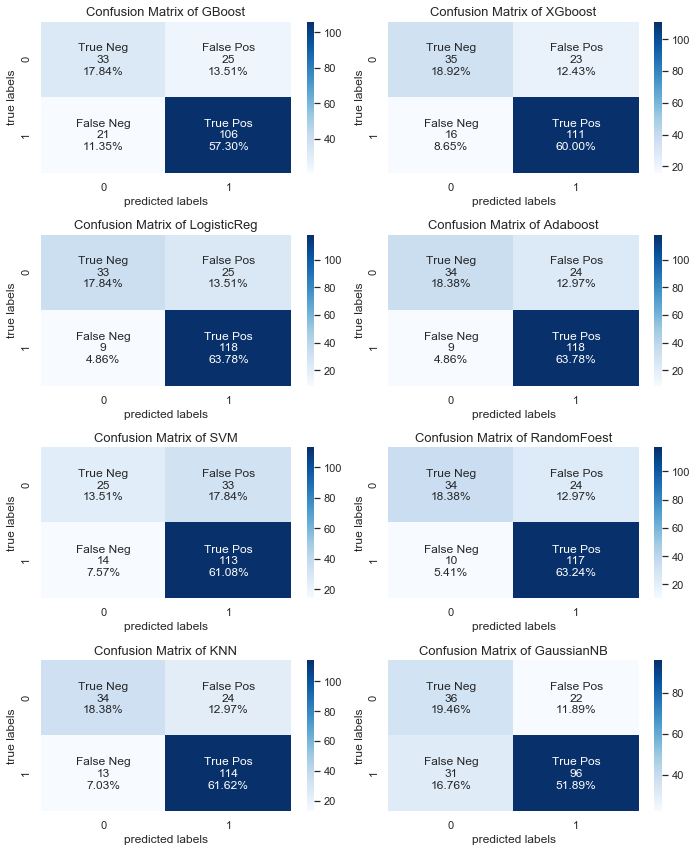

In [49]:
# visualizing confusion matrix  with the help of heatmaps.
model_index = [0,1,2,3,4,5,6,7]
model = ['GBoost','XGboost','LogisticReg','Adaboost','SVM','RandomFoest','KNN','GaussianNB']

for index ,model, model_name in zip(model_index,best_estimator_list,model):
    plt.subplot(4,2, index + 1 )
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    c_matric = confusion_matrix(y_test, y_pred)
    groups = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                c_matric.flatten()]
    group_percent = ['{0:.2%}'.format(value) for value in
                     c_matric.flatten()/np.sum(c_matric)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(groups,group_counts,group_percent)]
    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(c_matric, annot=labels, fmt='', cmap='Blues')
    plt.title('Confusion Matrix of ' + model_name, fontsize = 13)
    plt.ylabel('true labels')
    plt.xlabel('predicted labels')
    fig, ax = plt.gcf(), plt.gca()
    fig.set_size_inches(10, 12)
    plt.tight_layout()
plt.show()

From above heatmaps, we can see the models - Logistic Regression and Adaboost has the lowest 'Type-II' errors (i.e. having lowest False Negatives) and highest True Positives, which gives a loan company a better assurance in not losing a potential applicant/customer  because on rejection of his/her loan.

On the other hand, we also see models like GaussianNB, in which the 'Type-I' errors (i.e. having lowest False Positives) are lowest and  True negatives are highest, which gives a loan company a better assurance for detecting bad applicants/customers (in which there may be potential risk of failing to repay the loan amount by the applicant).

Therefore, by analysing the heatmaps and above statements, the model Adaboost gives us the best balanced result in reducing both 'Type-I' and 'Type-II' errors, which implies high f1 score for Adaboost model.

Therefore, we choose Adaboost as the final model for this project.

In [50]:
# selecting the best performing model.
selected_model = AdaBoostClassifier(learning_rate=0.3, random_state=41) 
selected_model.fit(x_train, y_train)
y_pred = selected_model.predict(x_test)

In [51]:
test_df = pd.DataFrame({'Actual Loan Status':y_test.values,'Predicted Loan Status':y_pred})

In [52]:
test_df.to_csv('loan_status_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [53]:
# Saving the final model as AdaBoostClassifier
import joblib

joblib.dump(selected_model, 'loan_status_pred.obj')
print('Model successfully saved.')

Model successfully saved.
